In [ ]:
# %% [markdown

# %%
# Install MNE library
!pip install mne -q

# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive

# ### 1. Data Loading and MNE Object Creation
# %%
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load the Data
# Use your specific path here
file_path = '/content/drive/Othercomputers/My Mac/Downloads/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
mat_data = scipy.io.loadmat(file_path)

# 3. Extract & Reshape EEG Signal
signal = mat_data['Signal']
n_epochs, n_samples, n_chans = signal.shape
# Transpose to (Channels, Epochs, Samples) then flatten to (Channels, Total_Time)
reshaped_signal = signal.transpose(2, 0, 1).reshape(n_chans, -1)
reshaped_signal = reshaped_signal * 1e-6  # Convert microvolts to Volts

# 4. Process Marker Channels
flashing = mat_data['Flashing'].flatten()
stim_type = mat_data['StimulusType'].flatten() # Target (1) vs Non-Target (0)

# 5. Construct MNE Events
onsets = np.where(np.diff(flashing, prepend=0) == 1)[0]
event_ids_raw = stim_type[onsets] + 1 # Convert to 1 (Non-Target) and 2 (Target)
events = np.column_stack((onsets, np.zeros_like(onsets), event_ids_raw.astype(int)))

# 6. Create MNE Raw Object
sfreq = 240.0
ch_names = [f'EEG_{i+1}' for i in range(n_chans)]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(reshaped_signal, info)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-3657615347.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


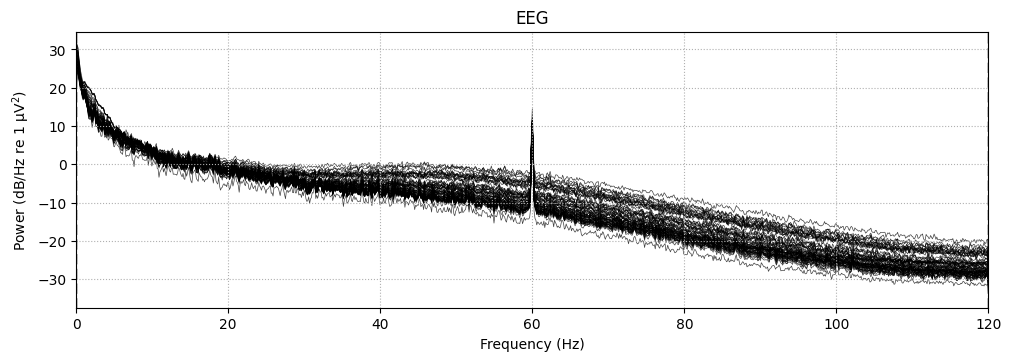

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)

Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-3657615347.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


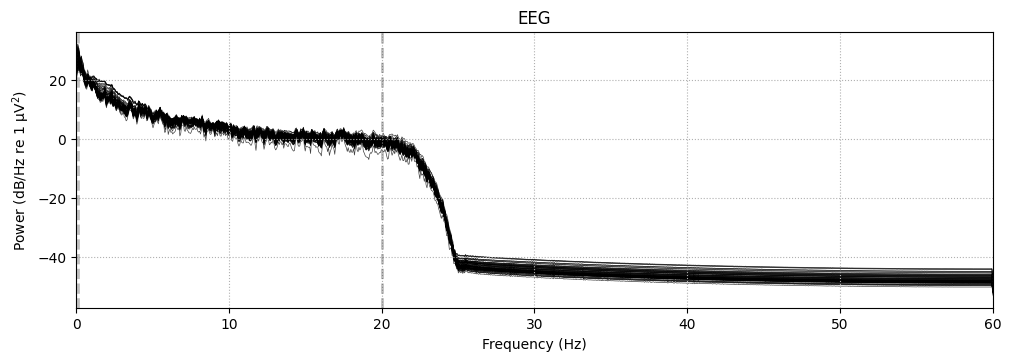

In [ ]:
# ### 2. Filtering and Resampling
# %%
# 1. Visualize PSD BEFORE
raw.compute_psd().plot()
plt.show()

# 2. Apply Band-pass Filter (0.1Hz - 20Hz)
raw.filter(l_freq=0.1, h_freq=20.0, fir_design='firwin') #

# 3. Downsample (240Hz -> 120Hz)
raw, events = raw.resample(sfreq=120.0, events=events) #

# 4. Visualize PSD AFTER
raw.compute_psd().plot()
plt.show()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 397 samples (3.308 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 34 components
Fitting ICA took 98.8s.


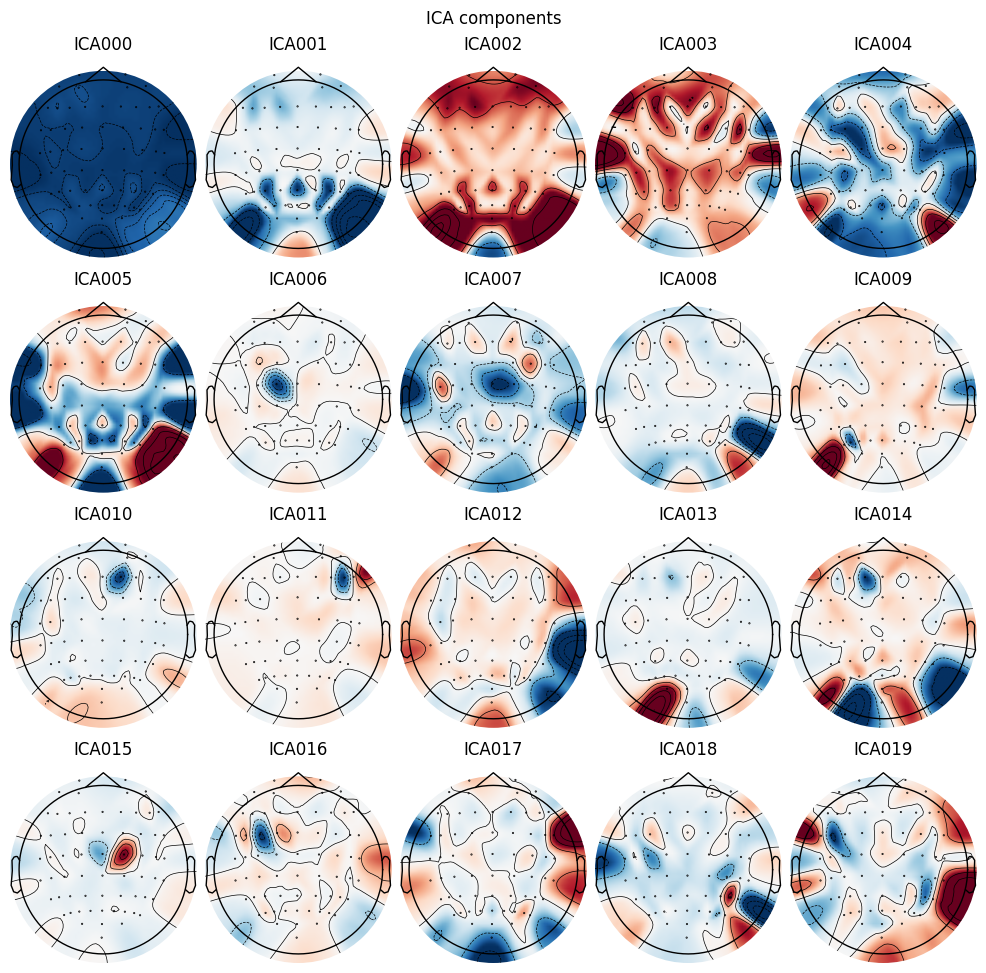

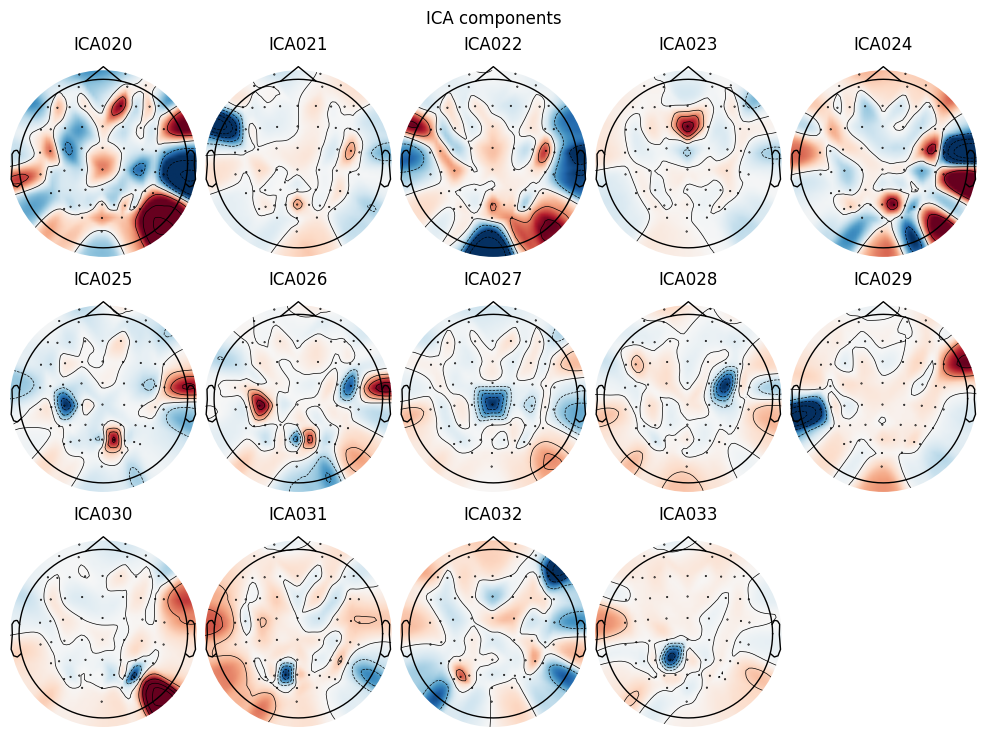

Creating RawArray with float64 data, n_channels=34, n_times=331245
    Range : 0 ... 331244 =      0.000 ...  2760.367 secs
Ready.
Using matplotlib as 2D backend.


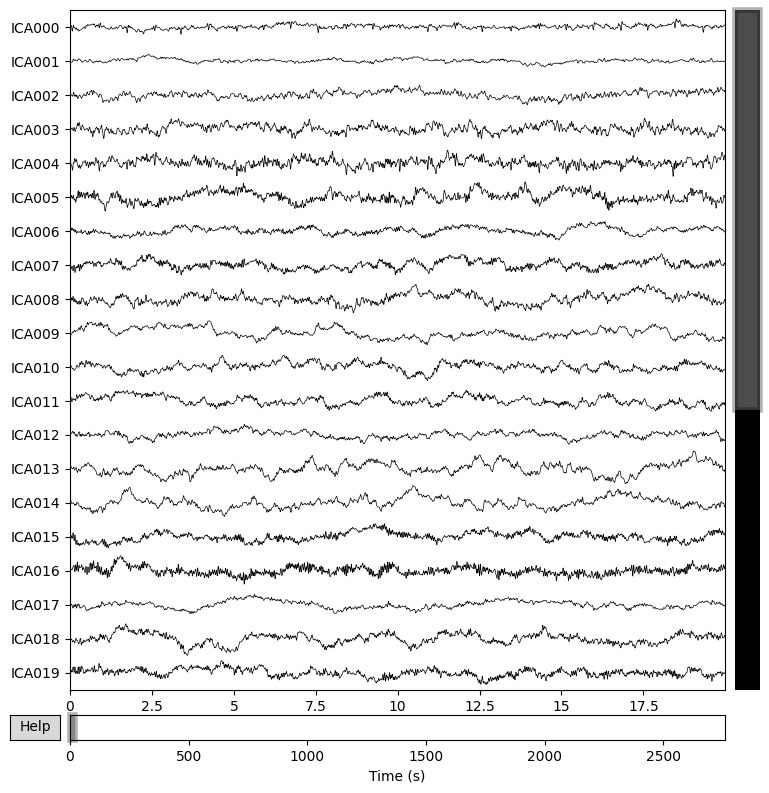

Applying ICA to Raw instance
    Transforming to ICA space (34 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>

In [ ]:
# ### 3. Channel Mapping and ICA
# %%
# 1. Corrected unique channel names (64 unique entries to fix naming error)
ch_names_std = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8',
    'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO7', 'PO3', 'PO4', 'PO8', 'O1', 'Oz', 'O2',
    'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6',
    'CP3', 'CPz', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'POz', 'PO6', 'PO1', 'PO2', 'FT7', 'FT8', 'TP7', 'TP8', 'Iz'
]

# Rename channels
mapping = {raw.ch_names[i]: ch_names_std[i] for i in range(len(ch_names_std))}
raw.rename_channels(mapping)
raw.set_montage('standard_1020') #

# 2. Initialize and Fit ICA
# Use n_components=0.95 to avoid shape mismatch errors
from mne.preprocessing import ICA
ica = ICA(n_components=0.95, method='fastica', random_state=42)
# Fit on a high-passed copy (1Hz) for better separation
ica.fit(raw.copy().filter(l_freq=1.0, h_freq=None))

# 3. Plot and Identify Artifacts
ica.plot_components()
ica.plot_sources(raw)
plt.show()

# 4. Exclude and Apply (Assuming component 0 is the blink)
ica.exclude = [0]
ica.apply(raw) #

Not setting metadata
15300 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15300 events and 109 original time points ...
1 bad epochs dropped
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


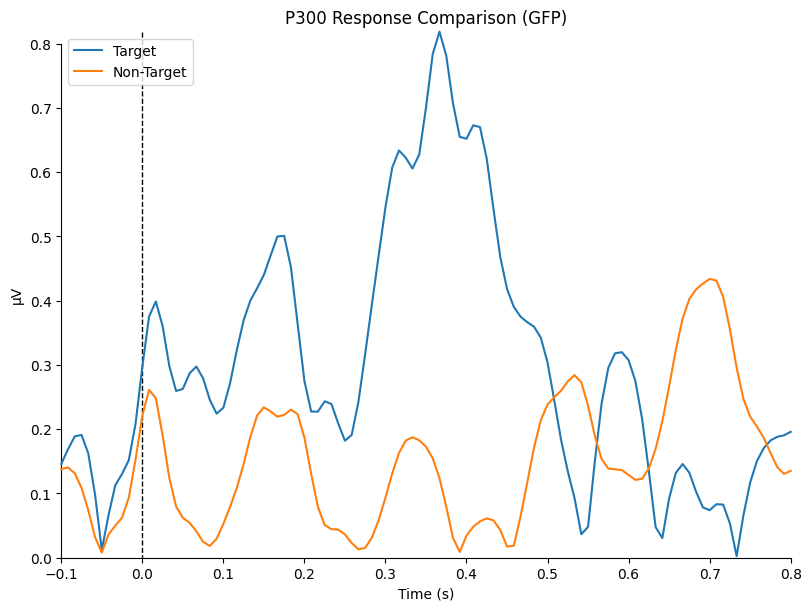

In [ ]:
# ### 4. Epoching and Evoked Response (P300)
# %%
# 1 & 2. Define Event IDs
event_dict = {'Non-Target': 1, 'Target': 2}

# 3. Create Epochs (-0.1s to 0.8s)
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.1, tmax=0.8,
                    baseline=(None, 0), preload=True) #

# 4. Compute Evoked Responses
evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

# 5. Visualize P300 Response at Cz and Pz

mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Non-Target': evoked_nontarget},
                             picks=['Cz', 'Pz'], title='P300 Response Comparison')
plt.show()